
# Introduction

This workshop aims at generating Land Surface Temperature (LST) and other relevant products (NDVI,Surface Emissivity, and  Fractional vegetation cover) for assessing urban climates (urban heat islands) from Landsat 8 imagery using open python geospatial tools.

We will use the city of Tallinn, Estonia's capital as our area of study. The image acquisition date is 27.07.2018, this day
is one of the series of days in the heatwave of 2018. LST is a widely used parameter to assess the impacts of heatwaves.


LST is the radiative skin temperature of the land surface. It is estimated from Top-of-Atmosphere brightness temperatures from the thermal bands of remote sensing imagery.Its estimation further depends on the surface albedo, the vegetation cover and the soil moisture.-- **Copernicus Global Land Services**

Several algorithms exist for calculating LST from remote sensing images, examples are split-window, dual-angle, and single channel.


In this workshop we will go through the workflow for calculating LST using the **single channel** approach by Jiménez-Muñoz et. al. 2009. 



## Data

Landsat imagery -(Green-3,Red-4, Near Infrared-5, and Thermal-10 bands)

The bands (3,4, and 5) are from landsat collection 2 and they are already processed to surface reflectance.

The thermal band is from landsat collection 1.

1 km Population Grids



## Key Python libraries

__[Intake](https://pypi.org/project/intake/)__

__[Rasterio](https://pypi.org/project/rasterio/)__

__[Earthpy](https://pypi.org/project/earthpy/)__

__[Numpy](https://numpy.org/)__

__[Geopandas](https://geopandas.org/index.html)__

__[Rasterstats](https://pypi.org/project/rasterstats/)__

__[Geocube](https://pypi.org/project/geocube/)__

__[Matplotlib](https://matplotlib.org/stable/index.html#)__

## Workflow

![WORKFLOW](workflow.png)




## Outputs
The final outputs for this workshop will be a 1 Km grided map of the LST for the city of Tallinn, Estonia and a datacube
of LST and NDVI.




In [1]:
#import the needed packages

import intake

import numpy as np
import pandas as pd

import rasterio as rio
from rasterio.crs import CRS


import geopandas as gpd
import earthpy as et
import earthpy.plot as ep
from geocube.api.core import make_geocube
from rasterstats import zonal_stats
from affine import Affine



import matplotlib.pyplot as plt
import matplotlib.colors as mcl

import warnings
warnings.filterwarnings('ignore')

The relevant data for this workshop is accessible through the intake catalog in the Data folder.

The catalog contains a stack of the relevant bands (3,4,5, and 10), 1 km grids, population data at 1 km and atmospheric parameters.

The data is accessible at this __[Data Repo](https://owncloud.ut.ee/owncloud/index.php/s/RJefY58gpaNakyg)__ 




A quick look of the extent of the satellite image and the study area

![Study Area](area.png)

In [4]:
# open data catalog
cat = intake.open_catalog('SC52_cat.yml')

cat.discover()


# View components of catalog

list (cat)



['atm_params', 'grids_1000_utm', 'stacked_bands']



We will access the stacked_bands in the catalog, have an overview and fetch the individual bands we will be using.



In [5]:
stack = cat.stacked_bands.read() #read stacked bands in the catalog

stack

<xarray.DataArray (band: 4, y: 2860, x: 3600)>
array([[[ 7749,  7760,  7750, ...,     0,     0,     0],
        [ 7751,  7740,  7747, ...,     0,     0,     0],
        [ 7750,  7738,  7754, ...,     0,     0,     0],
        ...,
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[ 7360,  7360,  7355, ...,     0,     0,     0],
        [ 7343,  7342,  7331, ...,     0,     0,     0],
        [ 7344,  7347,  7325, ...,     0,     0,     0],
        ...,
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[ 7202,  7193,  7192, ...,     0,     0,     0],
        [ 7199,  7177,  7188, ...,     0,     0,     0],
        [ 7180,  7192,  7185, ...,     0,     0,     0],
        ...,
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[25365, 25373, 25374, ...,     0,     0,     0],
        [25362, 25370, 25370, ...,     0,     0,     0],
        [25352, 25360, 25361, ...,     0,     0,     0],
        ...,
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]]], dtype=uint16)
Coordinates:
  * band     (band) int32 1 2 3 4
  * y        (y) float64 6.621e+06 6.621e+06 6.621e+06 ... 6.535e+06 6.535e+06
  * x        (x) float64 6.31e+05 6.31e+05 6.310e+05 ... 7.389e+05 7.39e+05
Attributes:
    transform:      (30.0, 0.0, 630975.0, 0.0, -30.0, 6621165.0)
    crs:            +init=epsg:32634
    res:            (30.0, 30.0)
    is_tiled:       0
    nodatavals:     (0.0, 0.0, 0.0, 0.0)
    scales:         (1.0, 1.0, 1.0, 1.0)
    offsets:        (0.0, 0.0, 0.0, 0.0)
    AREA_OR_POINT:  Area

Now, we will proceed to selecting the individual bands (arrays) in the stack as numpy arrays.

We will do that by using indices. The bands are arranged in the order (Green-3,Red-4, Near Infrared-5, and Thermal-10 bands) which match the indices 0, 1, 2, and 3 in the stack, respectively.

In [6]:


b4 = np.array(stack[1])#red band

b5= np.array(stack[2]) # NIR band

b10 = np.array(stack[3]) #thermal band




Now we will do same for the other datasets in the catalog.

we will read and have a preview for each.

In [7]:
grids = cat.grids_1000_utm.read()  #pop grids

grids.head(10) #view first ten rows 


,GRD_INSPIR,geometry
0,1kmN6583E0537,"MULTIPOLYGON (((707354.995 6588429.239, 707309..."
1,1kmN6583E0538,"MULTIPOLYGON (((708354.095 6588474.383, 708308..."
2,1kmN6590E0538,"MULTIPOLYGON (((708018.113 6595906.810, 708016..."
3,1kmN6587E0534,"MULTIPOLYGON (((704640.951 6593312.208, 705131..."
4,1kmN6589E0535,"MULTIPOLYGON (((705085.894 6594333.436, 705043..."
5,1kmN6581E0534,"MULTIPOLYGON (((705437.381 6586555.427, 705447..."
6,1kmN6584E0545,"MULTIPOLYGON (((715302.769 6589789.596, 715267..."
7,1kmN6580E0542,"MULTIPOLYGON (((712471.896 6585969.456, 712440..."
8,1kmN6581E0542,"MULTIPOLYGON (((712440.843 6586656.734, 712395..."
9,1kmN6582E0542,"MULTIPOLYGON (((712395.696 6587655.860, 712350..."


<AxesSubplot:>

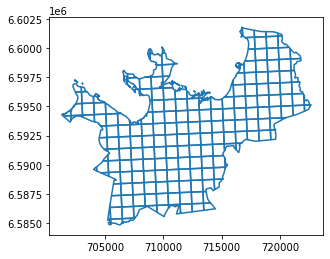

In [8]:
#quick plot of grids

grids.boundary.plot()

In [9]:
atm_params = cat.atm_params.read()  #atm corr params

atm_params #view atmospheric parameters

['Band average atmospheric transmission:    0.65\n',
 'Effective bandpass upwelling radiance:    2.82 W/m^2/sr/um\n',
 'Effective bandpass downwelling radiance:  4.41 W/m^2/sr/um ']

Since we will be visualizing our intermediate and final outputs,we will create custom color maps for the parameters of interest. 

we will use standard colors that are used in representing these parameters usually.

We will use the LinearSegmentedColormap in matplotlib by passing a list of colours.


In [10]:
#create custom colour map
lst_cmap = mcl.LinearSegmentedColormap.from_list("", ["blue","lightskyblue","yellow","orange",'red'])

#create custom colour map
ndvi_cmap = mcl.LinearSegmentedColormap.from_list("", ["red","yellow","greenyellow","limegreen",'forestgreen','darkgreen'])


#create custom colour map
pop_cmap = mcl.LinearSegmentedColormap.from_list("", ["khaki","yellow","orange","darkgoldenrod","saddlebrown","maroon"])

Now we are set to go through the workflow having read all the needed data.

## **Calculate NDVI**

NDVI is the Normalized Difference Vegetation Index. It is arguably the most used index for vegetation assessment. 

Since the late 1960s researchers have used red and near-infrared light to estimate vegetation abundance using the NDVI.

The index is also used for urban climate studies.

NDVI values range from **-1 to +1**. Negative values signify bare lands while positive values signify vegetated surfaces.

The higher the positive value, the 'healthier' the vegetation or the more green the area. Urban regions have lower positive values usually.

The formula is given by:



$NDVI = \frac{\rho_{NIR} - \rho_{Red}}{\rho_{NIR} + \rho_{Red}}$

where $ \rho_{NIR} $ is the near-infrared band and $ \rho_{Red} $ is the red band.

the red band for landsat 8 is band 4 and the near-infrared is band 5


In [11]:
np.seterr(divide='ignore', invalid='ignore') #allow for the division by zero

ndvi = (b5.astype(float)-b4.astype(float))/(b5+b4) # calculate NDVI



ndvi

array([[-0.01085016, -0.0114753 , -0.01120506, ...,         nan,
                nan,         nan],
       [-0.00990235, -0.01136442, -0.00984916, ...,         nan,
                nan,         nan],
       [-0.01129166, -0.01066098, -0.00964852, ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])

Let us visualize our first intermediate results-NDVI.

We will use the earthpy.plot which is a plot function in earthy built on matplotlib.

We will also use this first visualisation to have an idea of the coverage of the image and study area.

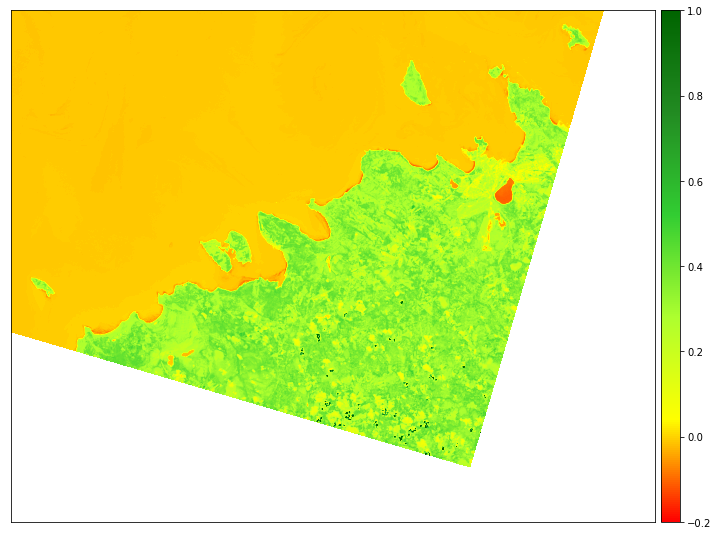

<AxesSubplot:>

In [12]:
#visualize NDVI output

ep.plot_bands(ndvi, cmap=ndvi_cmap, vmin=-0.2,vmax=1)




**Calculate Fractional Vegetation Cover (FVC)**

Fractional vegetation cover (FVC) is the ratio of vertically projected area of vegetation to the total surface extent.

It is a controlling factor in transpiration, photosynthesis, global climate changes and other terrestrial processes and climate models.

FVC is essential for calculating the land surface emmisivity. It can be estimated from the NDVI according to the following formula
 
$$ FVC =  \frac{NDVI - NDVI_{soil}  }  {NDVI_{veg} +  NDVI_{soil}}$$ 

where $NDVI_{soil}$ is given as **0.2** and  $NDVI_{veg}$ is given as **0.5** (Sobrino et al. 2004; Yu et al. 2014)



In [13]:
#calculate the fvc

fvc = (ndvi-0.2)/(0.5-0.2)

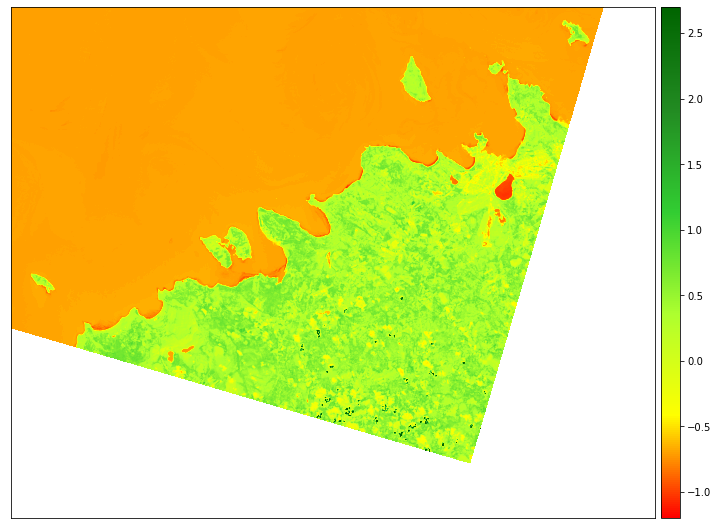

<AxesSubplot:>

In [14]:
ep.plot_bands(fvc, cmap=ndvi_cmap,vmin=-1.2, vmax=2.7)

The emissivity (ε) of a material is the relative ability of its surface to emit heat by radiation.

The strength of the energy emitted depends on both the temperature of the surface and how efficiently it can emit radiation.

The emissivity of most natural Earth surfaces is a unitless quantity and ranges between approximately 0.6 and 1.0, but surfaces with emissivities less than 0.85 are typically restricted to deserts and semi-arid areas. Vegetation, water and ice have high emissivities above 0.95 in the thermal infrared wavelength range- __[NASA](https://www.jpl.nasa.gov/images/nasa-spacecraft-maps-earths-global-emissivity)__


To estimate land surface emissivity (LSE) of mixed pixels using the equation from (Sobrino et al. 2004):
    
    
$$ \varepsilon =  \varepsilon_s(1-FVC)+ \varepsilon_v(FVC)  $$

where $ \varepsilon_s $  and $ \varepsilon_v $  are emissivity values for soil and vegetation, respectively.


The emissivity values for soil and vegetation estimated at 0.97 and 0.99 respectively.


We will go through the image and calculate the emissivity for each pixel using the NDVI threshold method.

For

$NDVI ≤ 0.2$ : $LSE = 0.97$ - bare soils (low vegetaton)



$NDVI ≥ 0.5$ : $LSE = 0.99$ - mostly (healthy) vegetation


$0.2 < NDVI < 0.5$ : $LSE = 0.971*(1-fvc)+0.987*fvc$

In [15]:

emi = []

for row in range(len(ndvi)):                         #each row in the ndvi array
    
    emrow=[]                                              #emissivity of the row
    
    for i in range(len(ndvi[row])):                  #for each pixel in the row
        
        if ndvi[row][i] ==np.nan:
            emrow.append(np.nan)
            
        elif ndvi[row][i]<= 0.2:                    
            emrow.append(0.97)
            
        elif ndvi[row][i]>= 0.5:
            emrow.append(0.99)
            
        else:
            emrow.append(0.971*(1-fvc[row][i])+(0.987*fvc[row][i]))
    emi.append(emrow)
    
    
emiss = np.asarray(emi) #convert the emi to np array    

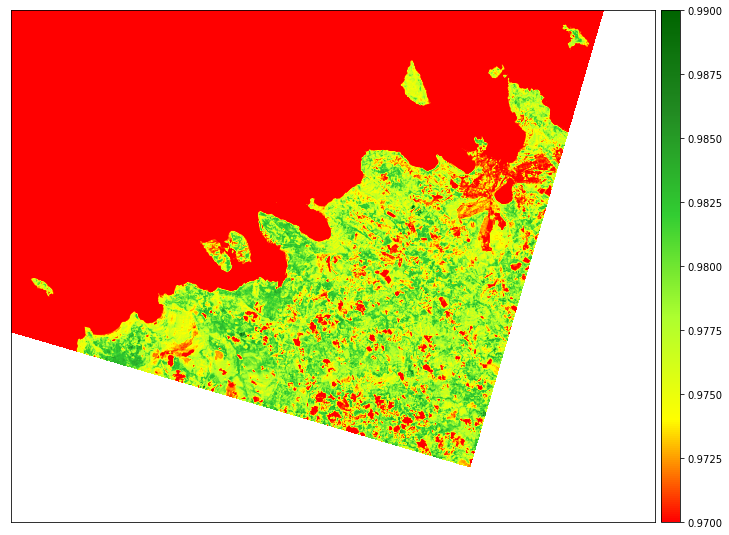

<AxesSubplot:>

In [16]:
ep.plot_bands(emiss, cmap=ndvi_cmap)

## **Calculate LST**

Now, we will move on to process the thermal band to calculate the LST.

we will calculate the at sensor radiance (convert digital numbers to radiance); brightness temperature and two parameters based on Planck's functions which are needed to calculate LST.

The LST formular is given by :
    

    
$ lst = \gamma [\frac{1}{\varepsilon} (\psi_1*toa + \psi_2) + \psi_3] + \delta\\ $

$ \gamma $ and $ \delta$ which are parameters based on Planck's funtions

$ \varepsilon$ is emissivity

$\psi_1$, $\psi_2$ , and $\psi_3$ are atmospheric functions

**toa** is the top of atmosphere radiance

In [17]:
#calculate at top of atmosphere radiance


toa = (b10.astype(float)*0.0003342)+0.1 #change mult constant if not L8


Now we will proceed to calculate the at-sensor brightness temperature (bt) using :

    
$bt = \frac{K_2}{In  (\frac{K_1}{toa}+1)} $
    

Also we will canulate $ \gamma $ and $ \delta$ which are parameters based on Planck's funtions:


$ \gamma = \frac {bt^2}  {K_2  *  toa}  $

$ \delta =  bt - \frac {bt^2}{K_2}  $

where $K_1$ and $K_2$ are thermal band constants provided in the metadata of the image.

For Landsat 8 $K_1$ = 774.8853 and $K_2$ = 1321.0789

In [18]:
#calculate at sensor brightness temperature and convert to degree cel

bt = (1321.0789 / np.log((774.8853 / toa) + 1)) - 273.15


#calculate delta and gamma -- parameters based on Plank's functions



gamma = (bt*bt)/(1321.0789*toa) 

delta = bt - ((bt*bt)/1321.0789) 






We calculate atmospheric functions $\psi_1$, $\psi_2$ , and $\psi_3$

from MODTRAN upwelling and downwelling estimations using the relationships in (Sobrino and Jiménez-Muñoz, 2010)
 
 
 
$ \psi_1 = \frac{1}{𝜏} $

$ \psi_2 = −𝐿^↓ − \frac{𝐿^↑}{𝜏}$
   
$ \psi_3 = 𝐿^↓ $



where $τ$ is the atmospheric transmissivity, $L^↑$ is the upwelling atmospheric radiance, and $L^↓$ is the downwelling atmospheric radiance. These parameters can be obtained from the online calculator at https://atmcorr.gsfc.nasa.gov/ by providing date and time of image acquisition found in the metadata

atm_params = cat.atm_params.read()

atm_params

In [19]:
#a look at the atm param

atm_params

['Band average atmospheric transmission:    0.65\n',
 'Effective bandpass upwelling radiance:    2.82 W/m^2/sr/um\n',
 'Effective bandpass downwelling radiance:  4.41 W/m^2/sr/um ']

In [20]:
#calcultate atm functions 




transmission = float(atm_params[0][atm_params[0].find(':')+1:].strip())

upwelling_radiance= float(atm_params[1][atm_params[1].find(':')+4:atm_params[1].find('W')-1].
                          strip())

downwelling_radiance= float(atm_params[2][atm_params[2].find(':')+2:atm_params[2].find('W')-1].
                            strip())



w1 = 1/transmission

w2 =(-1*downwelling_radiance) - (upwelling_radiance/transmission)

w3 = downwelling_radiance





print ('transmission:',transmission,' upwelling_radiance:',upwelling_radiance,' downwelling_radiance:',downwelling_radiance)

transmission: 0.65  upwelling_radiance: 2.82  downwelling_radiance: 4.41


Up until now we have generated all the required parameters to calculate the Land Surface Temperature.

Now we can go ahead and calculate the lst

The LST formular is given by :
    

    
$ lst = \gamma [\frac{1}{\varepsilon} (\psi_1*toa + \psi_2) + \psi_3] + \delta\\ $

In [21]:
lst = gamma*((((1/emiss)*((w1*toa)+w2)) + w3))+delta

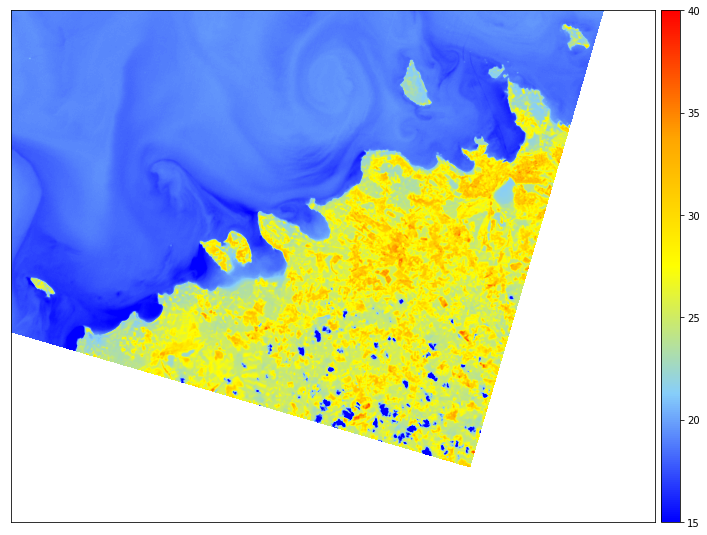

<function matplotlib.pyplot.show(close=None, block=None)>

In [22]:
ep.plot_bands(lst, cmap=lst_cmap ,
              scale=False,
            vmin=15, vmax=40)
plt.show

## Extration of LST and NDVI to grids

Now, we will extract the data for our area of interest using the 1km population grids. 

we will extract the NDVI and the LST for each grid using zonal statistics.

To perform the zonal statistics, we will use rasterstats. we will require the transformation information from the imagery as one of the arguments for the zonal statistics.

In [23]:
#fetch transformation info and use the affine method

transform = stack.transform

print(transform)

(30.0, 0.0, 630975.0, 0.0, -30.0, 6621165.0)


The Affine method accepts 5 positional arguments. We can either copy the values we printed in the previous 
cell or access each element in the tuple and pass them to the Affine method. Copying is simple.

In [24]:
#create affine transformation using affine method

trans = Affine(30.0, 0.0, 630975.0, 0.0, -30.0, 6621165.0)

trans

Affine(30.0, 0.0, 630975.0,
       0.0, -30.0, 6621165.0)

In [25]:
#zonal stats for NDVI 

sampled_ndvi = zonal_stats(grids,                       #define polygon feature (grids)
                            ndvi,                       #input raster
                            stats='mean',               #statistic of interest
                            geojson_out=True,           #output as geojson
                            affine = trans)             #transformation



#Zonal stats for LST

sampled_lst = zonal_stats(grids, 
                          lst,
                          stats='mean',
                          geojson_out=True,
                          affine = trans)




In [ ]:
#sampled_lst

The output of the zonal stats is  geojson. We will convert it to GeoDataFrame.

In [26]:
#sampled_ndvi geojson to GeoDataFrame
sampled_ndvi_gdf = gpd.GeoDataFrame.from_features(sampled_ndvi)




#sampled_lst geojson to GeoDataFrame
sampled_lst_gdf = gpd.GeoDataFrame.from_features(sampled_lst)

In [27]:
sampled_ndvi_gdf.head(5)

,geometry,GRD_INSPIR,mean
0,"MULTIPOLYGON (((707354.995 6588429.239, 707309...",1kmN6583E0537,0.257685
1,"MULTIPOLYGON (((708354.095 6588474.383, 708308...",1kmN6583E0538,0.247447
2,"MULTIPOLYGON (((708018.113 6595906.810, 708016...",1kmN6590E0538,0.207952
3,"MULTIPOLYGON (((704640.951 6593312.208, 705131...",1kmN6587E0534,0.100743
4,"MULTIPOLYGON (((705085.894 6594333.436, 705043...",1kmN6589E0535,0.284669


In [28]:
sampled_lst_gdf.head(5)

,geometry,GRD_INSPIR,mean
0,"MULTIPOLYGON (((707354.995 6588429.239, 707309...",1kmN6583E0537,27.213695
1,"MULTIPOLYGON (((708354.095 6588474.383, 708308...",1kmN6583E0538,27.458019
2,"MULTIPOLYGON (((708018.113 6595906.810, 708016...",1kmN6590E0538,27.857632
3,"MULTIPOLYGON (((704640.951 6593312.208, 705131...",1kmN6587E0534,25.243186
4,"MULTIPOLYGON (((705085.894 6594333.436, 705043...",1kmN6589E0535,23.920792


Let us put the sampled ndvi and lst in the grids dataframe.

In [29]:
grids['ndvi'] = sampled_ndvi_gdf['mean'].round(2)    #round extracted values to 2 dp


grids['lst'] = sampled_lst_gdf['mean'].round(2)



In [30]:
grids.head(5)

,GRD_INSPIR,geometry,ndvi,lst
0,1kmN6583E0537,"MULTIPOLYGON (((707354.995 6588429.239, 707309...",0.26,27.21
1,1kmN6583E0538,"MULTIPOLYGON (((708354.095 6588474.383, 708308...",0.25,27.46
2,1kmN6590E0538,"MULTIPOLYGON (((708018.113 6595906.810, 708016...",0.21,27.86
3,1kmN6587E0534,"MULTIPOLYGON (((704640.951 6593312.208, 705131...",0.10,25.24
4,1kmN6589E0535,"MULTIPOLYGON (((705085.894 6594333.436, 705043...",0.28,23.92


Now our grids dataframe has all the parameters of interest. 

Through out the workflow, we worked in UTM reference system, however we will like to our final exports to be in Estonian reference system - EPSG: 3301

In [31]:
grids = grids.to_crs('EPSG:3301') #reproject from utm to Estonian projected CRS

In [32]:
#Quick look at our grid data

grids.head(10)

,GRD_INSPIR,geometry,ndvi,lst
0,1kmN6583E0537,"MULTIPOLYGON (((537000.000 6583000.000, 537000...",0.26,27.21
1,1kmN6583E0538,"MULTIPOLYGON (((538000.000 6583000.000, 538000...",0.25,27.46
2,1kmN6590E0538,"MULTIPOLYGON (((538000.000 6590439.176, 538000...",0.21,27.86
3,1kmN6587E0534,"MULTIPOLYGON (((534509.437 6588000.000, 535000...",0.10,25.24
4,1kmN6589E0535,"MULTIPOLYGON (((535000.000 6589000.000, 535000...",0.28,23.92
5,1kmN6581E0534,"MULTIPOLYGON (((535000.000 6581214.843, 535000...",0.33,24.67
6,1kmN6584E0545,"MULTIPOLYGON (((545000.000 6584000.000, 545000...",0.28,25.56
7,1kmN6580E0542,"MULTIPOLYGON (((542000.000 6580312.123, 542000...",0.07,24.15
8,1kmN6581E0542,"MULTIPOLYGON (((542000.000 6581000.000, 542000...",0.20,24.87
9,1kmN6582E0542,"MULTIPOLYGON (((542000.000 6582000.000, 542000...",0.26,26.13


With all our desired information in one geodataframe, we can now visualize each parameter in the study area.

Let's start with plotting the NDVI and the LST side by side. 

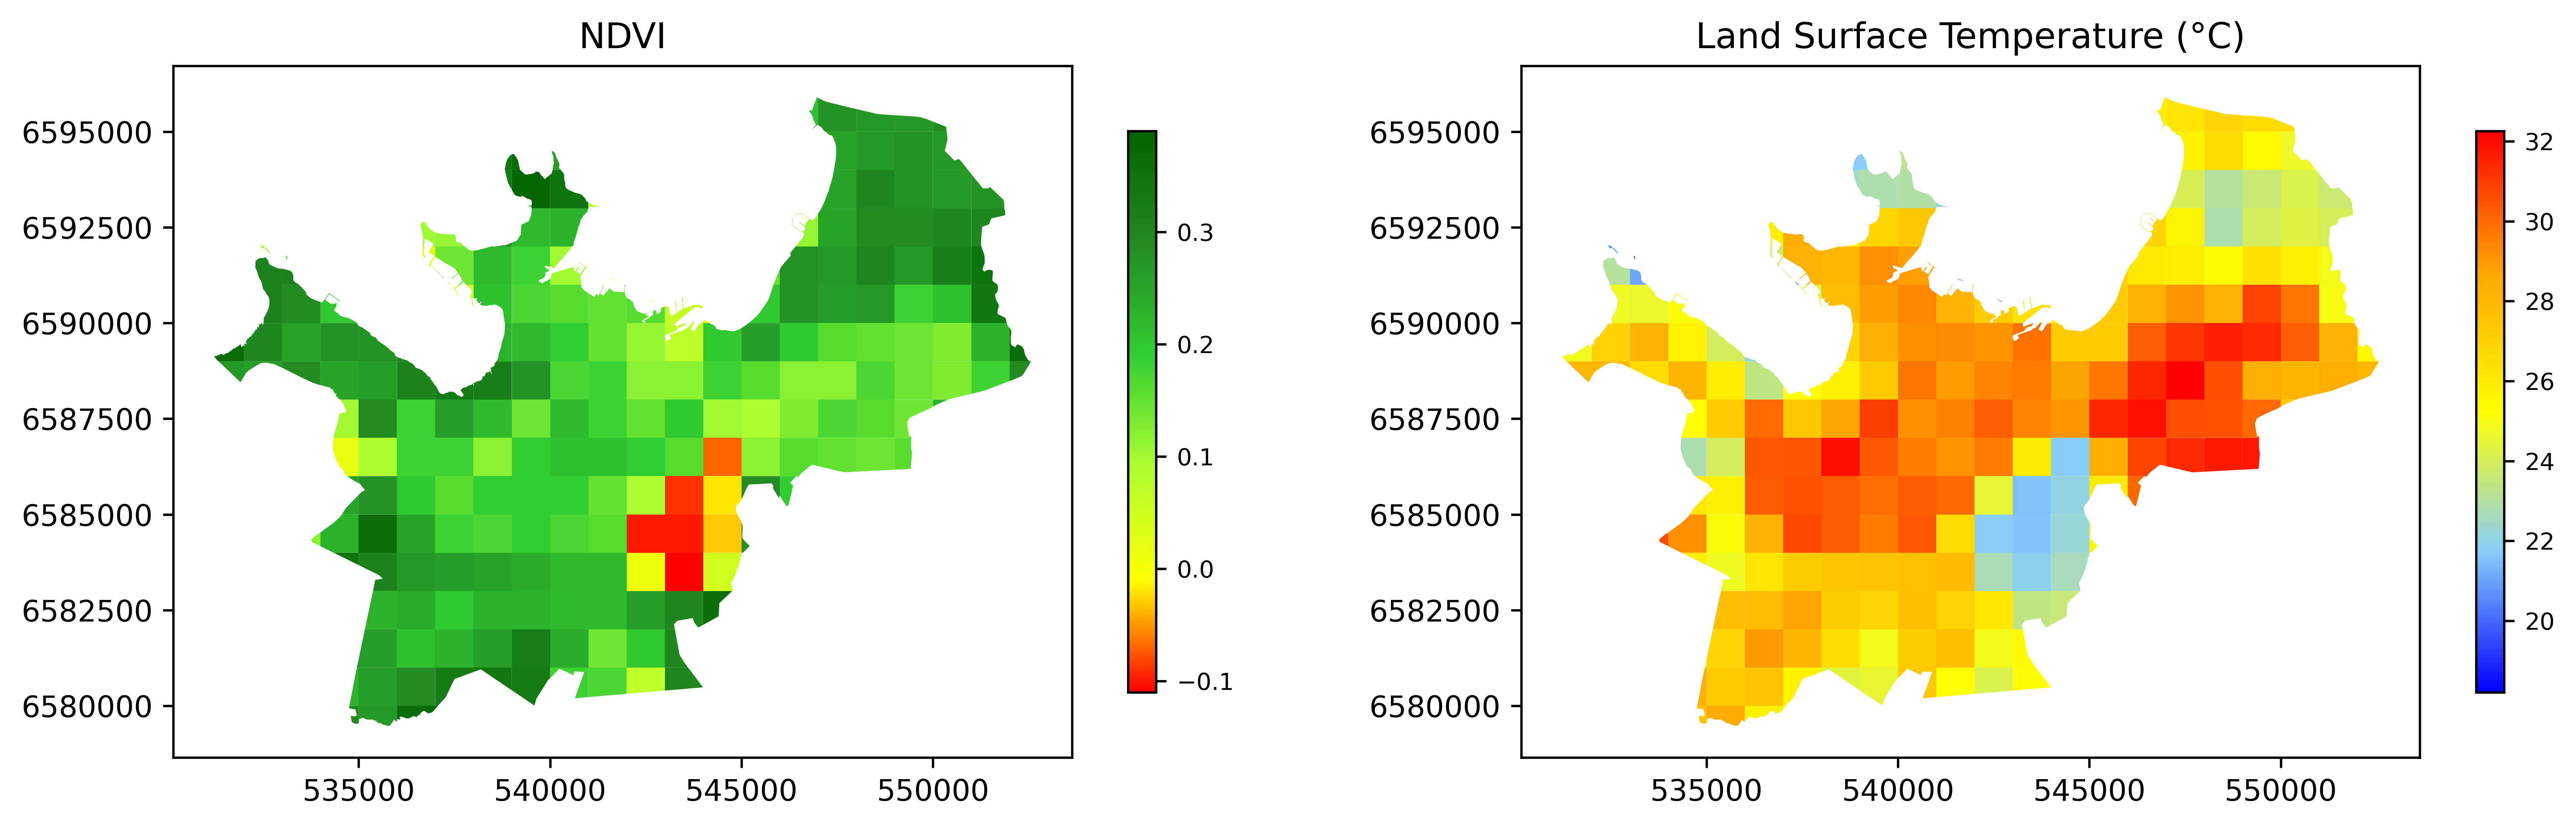

In [33]:
fig, axes = plt.subplots(1,2,figsize=(15,5),dpi=600) #create a figure with two subplots

ax1 , ax2 = axes.flatten() #flatten the axes to get individual matplotlib ax


#plot the LST in the first ax

ax2 = grids.plot(column='lst',     #define parameter of interest
                 cmap=lst_cmap,    
                 ax=ax2,           #set the ax 
                 legend=True,
                 legend_kwds={'shrink': 0.7})

#some extra tweaks to enhance the presentation

ax2.ticklabel_format(style='plain')
ax2.figure.axes[-1].tick_params(labelsize=8)
ax2.set_title('Land Surface Temperature (°C)')


ax1 = grids.plot(column='ndvi',     #define parameter of interest
                 cmap=ndvi_cmap,    
                 ax=ax1,           #set the ax 
                 legend=True,
                 legend_kwds={'shrink': 0.7})

ax1.ticklabel_format(style='plain')
ax1.figure.axes[-1].tick_params(labelsize=8)
ax1.set_title('NDVI')

plt.savefig('demo.png', dpi=600,
        transparent=False,
        frameon=None)

Finally, we will make a geocube (data cube) from the grids dataframe and export using geocube.

The geocube library is built on rasterio.

This is a convenient way to export both parameters in one shot. Another advantage is that you do not have to define meta parameters as you would when using rasterio

In [34]:
#make cube and export
cube = make_geocube(vector_data=grids, resolution=(1000, 1000))
    
    
cube.rio.to_raster('tallinn_lst_ndvi.tif')

### Some resources:

__[Github repo](https://github.com/LandscapeGeoinformatics/EGU_2021_lgeo_workshops)__ for this workshop.
    


__[How to download data](https://lta.cr.usgs.gov/sites/default/files/LS_C2_Help_122020.pd)__ 

Sobrino, J.A.; Jimenez-Muoz, J.C.; Soria, G.; Romaguera, M.; Guanter, L.; Moreno, J.;
Plaza, A.; Martinez, P., "Land Surface Emissivity Retrieval From Different VNIR and TIR Sensors," in Geoscience and Remote Sensing, IEEE Transactions on , vol.46, no.2, pp.316-
327, Feb. 2008 doi: 10.1109/TGRS.2007.904834
    
J. C. Jimenez-Munoz, J. Cristobal, J. A. Sobrino, G. Soria, M. Ninyerola and X. Pons, 
"Revision of the Single-Channel Algorithm for Land Surface Temperature Retrieval From Landsat Thermal-Infrared Data," 
in IEEE Transactions on Geoscience and Remote Sensing, vol. 47, no. 1, pp. 339-349, Jan. 2009, doi: 10.1109/TGRS.2008.2007125.
        
